#  <center><u>CAR VS TRUCK CLASSIFICATION

### INSTALLING TENSORFLOW (OPTIONAL)

In [2]:
!pip install tensorflow

     -------------------------------------- 272.8/272.8 MB 5.0 MB/s eta 0:00:00
     -------------------------------------- 422.5/422.5 kB 8.8 MB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 7.3 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB ? eta 0:00:00
     ---------------------------------------- 24.4/24.4 MB 5.9 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 5.6/5.6 MB 6.7 MB/s eta 0:00:00
     -------------------------------------- 440.7/440.7 kB 6.8 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 8.3 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyprojec

### SETUP

In [9]:
import tensorflow as tf
import os

In [15]:
gpus=tf.config.experimental.list_physical_devices('GPU')

In [16]:
gpus

[]

In [17]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for i in gpus:
    tf.config.experimental.set_memory_growth(i,True)

### REMOVING FAULTY IMAGES

In [2]:
import cv2
import imghdr

In [20]:
data_dir='data'
exts=['jpeg','jpg','png']
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        img_path=os.path.join(data_dir,image_class,image)
        try:
            img=cv2.imread(img_path)
            ex=imghdr.what(img_path)
            if ex not in exts:
                print("Invalid Image extension for ", img_path)
                os.remove(img_path)
        except Exception as e:
            print("Corrupted image ",img_path)
            #os.remove(img_path)

Invalid Image extension for  data\cars\koenigsegg-jesko-5.webp
Invalid Image extension for  data\cars\modern-cars-studio-room-3d-260nw-735402217.jpg
Invalid Image extension for  data\truck\2022-ford-f-series-super-duty.jpg
Invalid Image extension for  data\truck\american-style-truck-on-freeway-260nw-528660739.jpg
Invalid Image extension for  data\truck\blazo-x-35.jpg
Invalid Image extension for  data\truck\Brand_page_Super_Carry_500x889_mobile.webp
Invalid Image extension for  data\truck\fastest-trucks-lead.jpg
Invalid Image extension for  data\truck\Feature-Image-2023-02-06T100555.157.jpg
Invalid Image extension for  data\truck\long-trailer-fb.jpg
Invalid Image extension for  data\truck\profile1662380499.jpg
Invalid Image extension for  data\truck\profile1662380816.jpg
Invalid Image extension for  data\truck\profile1672739723.jpg
Invalid Image extension for  data\truck\semi-semitrailer-truck-tractor-highway.jpg
Invalid Image extension for  data\truck\truck-container-on-highway-cargo-2

In [22]:
len(os.listdir(os.path.join('data','cars')))

151

In [23]:
len(os.listdir(os.path.join('data','truck')))

287

### CREATING DATASET

In [6]:
# Importing modules

import numpy as np 
import matplotlib.pyplot as plt
from tensorflow import keras

In [27]:
data=keras.utils.image_dataset_from_directory('data')

Found 437 files belonging to 2 classes.


In [28]:
data_iterator=data.as_numpy_iterator()
batch=data_iterator.next()

In [39]:
batch[0].shape

(32, 256, 256, 3)

In [ ]:
# Truck - 1
# Car   - 0

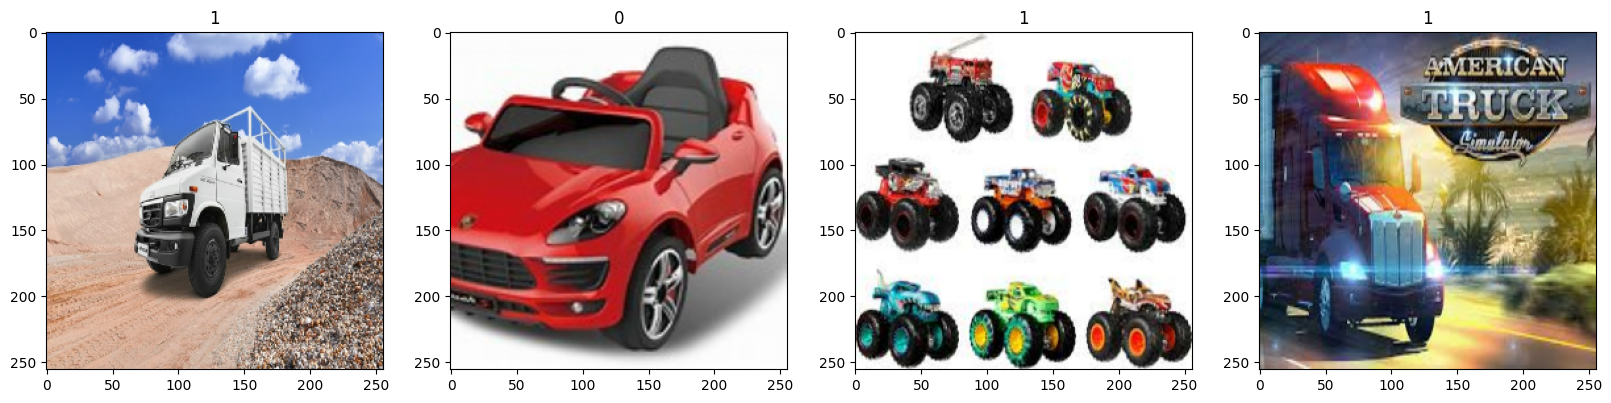

In [29]:
# Visualizing the images in a batch

fig,ax=plt.subplots(ncols=4,figsize=(20,20))
for idx,img in enumerate (batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### SPLITTING DATA

In [30]:
data=data.map(lambda x,y:(x/255,y))

In [31]:
len(data)

14

In [36]:
train_size=int(len(data)*.8)+1
val_size=int(len(data)*.1)
test_size=int(len(data)*.1)

In [35]:
int(len(data)*.1)

1

In [37]:
train=data.take(train_size)
val=data.skip(train_size).take(val_size)
test=data.skip(train_size + val_size).take(test_size)

### MODEL

In [38]:
from keras import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten

In [41]:
model=Sequential()

model.add(Conv2D(16,kernel_size=(3,3),padding='same',activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

model.add(Conv2D(32,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(1,activation='sigmoid'))


In [42]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)       0

### TRAINING MODEL

In [46]:
logdir='logs'

In [48]:
from keras.callbacks import TensorBoard,EarlyStopping

In [47]:
tensorboard_callback=TensorBoard(log_dir=logdir)

In [49]:
es=EarlyStopping(
    monitor='val_loss',
    min_delta=0.00001,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False)

In [50]:
history=model.fit(train,epochs=100,validation_data=val,callbacks=[tensorboard_callback,es])

Epoch 1/100
12/12 [==============================] - 16s 1s/step - loss: 0.7761 - accuracy: 0.5859 - val_loss: 0.6118 - val_accuracy: 0.6875
Epoch 2/100
12/12 [==============================] - 15s 1s/step - loss: 0.5916 - accuracy: 0.6875 - val_loss: 0.4902 - val_accuracy: 0.7500
Epoch 3/100
12/12 [==============================] - 15s 1s/step - loss: 0.4562 - accuracy: 0.8047 - val_loss: 0.2370 - val_accuracy: 0.9375
Epoch 4/100
12/12 [==============================] - 15s 1s/step - loss: 0.3643 - accuracy: 0.8568 - val_loss: 0.2414 - val_accuracy: 0.9375
Epoch 5/100
12/12 [==============================] - 15s 1s/step - loss: 0.2588 - accuracy: 0.9036 - val_loss: 0.0875 - val_accuracy: 1.0000
Epoch 6/100
12/12 [==============================] - 15s 1s/step - loss: 0.1593 - accuracy: 0.9583 - val_loss: 0.1587 - val_accuracy: 0.9375
Epoch 7/100
12/12 [==============================] - 15s 1s/step - loss: 0.0709 - accuracy: 0.9818 - val_loss: 0.0417 - val_accuracy: 1.0000
Epoch 8/100
1

### PERFORMANCE

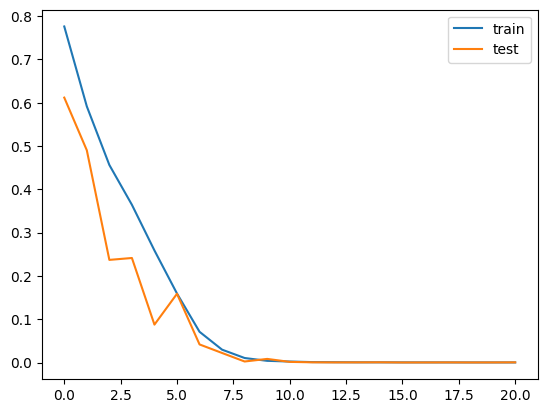

In [52]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

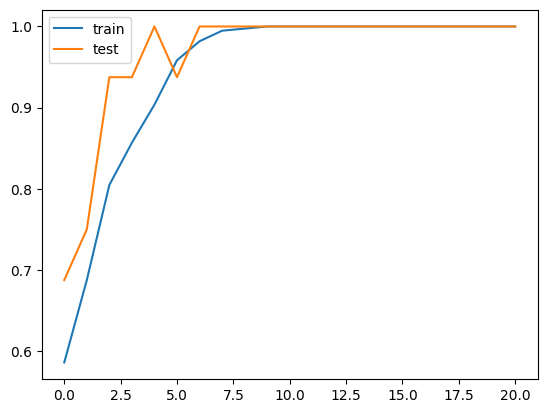

In [53]:
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.show()

### EVALUATING MODEL USING TEST DATA

In [54]:
from keras.metrics import Precision,Recall,BinaryAccuracy

In [55]:
p=Precision()
r=Recall()
a=BinaryAccuracy()

In [56]:
for batch in test.as_numpy_iterator():
    x,y=batch
    ypred=model.predict(x)
    p.update_state(y,ypred)
    r.update_state(y,ypred)
    a.update_state(y,ypred)

1/1 [==============================] - 0s 251ms/step


In [58]:
print("Precision : ",p.result().numpy(),', Recall : ',r.result().numpy(),', Accuracy : ',a.result().numpy())

Precision :  1.0 , Recall :  1.0 , Accuracy :  1.0


### TESTING WITH UNSEEN IMAGES

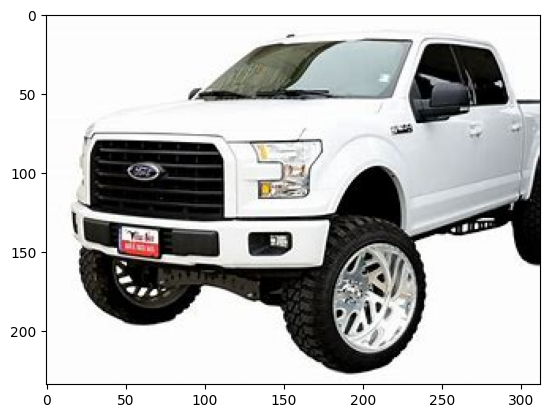

In [7]:
img_T=cv2.imread('truck_test_image.jpg')
plt.imshow(cv2.cvtColor(img_T,cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
# RESIZING IMAGE

resize=tf.image.resize(img_T,(256,256))

In [11]:
# MODEL CAN TAKE IN IMAGES ONLY IN BATCHES
np.expand_dims(resize/255,0).shape

(1, 256, 256, 3)

In [14]:
ypred_T=model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 334ms/step


In [15]:
print(ypred_T)

[[0.6630123]]


In [16]:
if ypred_T>0.5:
    print("The image is a Truck")
else:
    print("The image is a Car")

The image is a Truck


### SAVING MODEL

In [67]:
model.save(os.path.join('models','CarVsTruckmodel.h5'))

### RELOADING MODEL

In [3]:
from keras.models import load_model

In [13]:
model=load_model(os.path.join('models','CarVsTruckmodel.h5'))

### DOING PREDICTION ON RELOADED MODEL

In [88]:
ypred_new=new_model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 87ms/step


In [89]:
print(ypred_new)

[[0.99999964]]


In [74]:
if ypred_new>0.5:
    print("The image is a Truck")
else:
    print("The image is a Car")

The image is a Truck
